In [2]:
# import and preprocess data

import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv("hf://datasets/nprak26/remote-worker-productivity/remote_work_productivity.csv")
df

/Users/farns/miniforge3/envs/datavis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Employee_ID,Age,Years_Experience,WFH_Days_Per_Week,Gender,Education_Level,Marital_Status,Has_Children,Location_Type,Department,...,Quality_Score,Innovation_Score,Efficiency_Rating,Meetings_Per_Week,Commute_Time_Minutes,Job_Satisfaction,Stress_Level,Work_Life_Balance,Survey_Date,Response_Quality
0,EMP0001,39,10,2,Female,Associate Degree,Married,Yes,Urban,Product,...,58.1,52.1,72.1,4,48,55.9,6,8,2024-04-05,Medium
1,EMP0002,33,4,5,Female,Master Degree,Married,No,Urban,Customer Success,...,93.3,77.9,89.5,12,0,96.1,3,8,2024-01-29,High
2,EMP0003,40,3,3,Male,PhD,Single,Yes,Rural,Operations,...,84.7,63.2,95.0,15,24,90.4,5,6,2024-01-18,High
3,EMP0004,48,14,3,Male,Bachelor Degree,Married,Yes,Urban,Finance,...,67.8,82.5,95.0,8,8,100.0,10,5,2024-04-18,High
4,EMP0005,32,6,5,Male,High School,Divorced,Yes,Rural,Engineering,...,86.4,67.5,95.0,10,0,100.0,3,4,2024-02-19,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,EMP1496,53,5,5,Male,Master Degree,Married,No,Urban,HR,...,84.1,58.3,89.4,9,0,71.4,8,5,2024-03-18,High
1496,EMP1497,53,9,3,Non-binary,Master Degree,Married,Yes,Suburban,Finance,...,74.7,54.2,87.2,3,11,95.8,8,8,2024-05-13,High
1497,EMP1498,45,2,4,Male,Associate Degree,Single,Yes,Suburban,Engineering,...,88.4,71.2,95.0,11,34,100.0,4,5,2024-04-15,High
1498,EMP1499,44,12,4,Female,Bachelor Degree,Single,Yes,Suburban,Operations,...,93.9,88.6,95.0,10,6,100.0,3,6,2024-02-21,Medium


In [3]:
# drop unnecessary cols and predicted col
X = df.drop(['Internet_Speed_Category','Response_Quality', 'Productivity_Score', 'Employee_ID'], axis=1)
y = df['Productivity_Score']

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=67
)



In [4]:
# encode categorical columns and normalize numerical columns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)




In [ ]:
# make model and hyperparam search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
model = GradientBoostingRegressor(random_state=67)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_preprocessed, y_train)



,estimator,GradientBoost...ndom_state=67)
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [25]:
print('parameters:', grid_search.best_params_)
print('cv score', grid_search.best_score_)
print('rmse score', np.sqrt(-grid_search.best_score_))

parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
cv score -15.840193043669368
rmse score 3.9799740003760538


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(X_test_preprocessed)

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'training rmse: {train_rmse:.4f}')
print(f'test rmse: {test_rmse:.4f}')
print(f'training r2: {train_r2:.4f}')
print(f'test r2: {test_r2:.4f}')

training rmse: 2.9906
test rmse: 4.0137
training r2: 0.9616
test r2: 0.9289


/var/folders/n_/dm8l9y_j4x140yxg7r_r6b9m0000gn/T/ipykernel_3222/1739718089.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


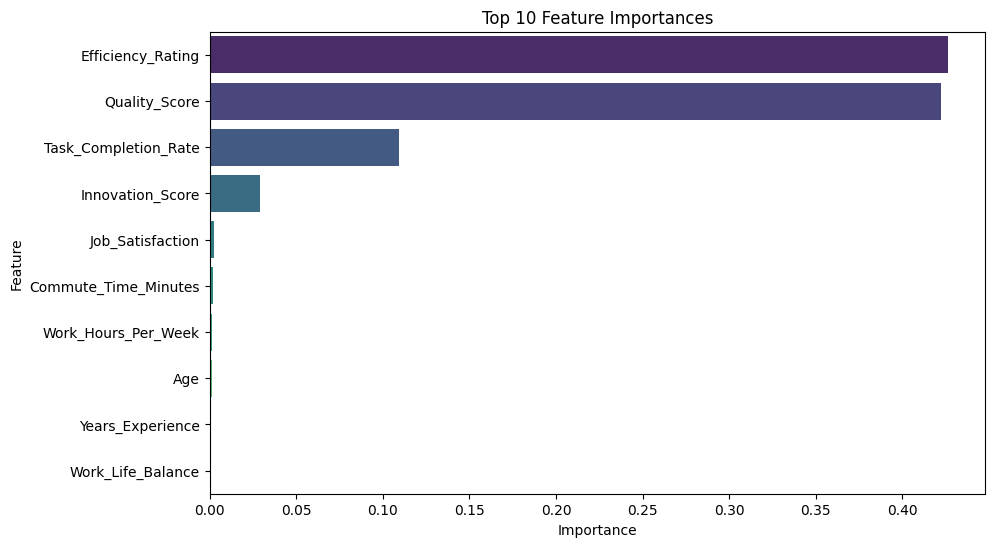

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

best_model = grid_search.best_estimator_

num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][2]

num_out = preprocessor.named_transformers_['num'].get_feature_names_out(num_features)
cat_out = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)

feature_names = list(num_out) + list(cat_out)

importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importances_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importances_df.head(10), 
    palette='viridis'
)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
